# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
import time as toc
%matplotlib inline

In [2]:
def STconvolve(x,k,dx,dt):
    output = np.zeros_like(x)
    for i in range(x.shape[0]):
        for ii in np.arange(max(i-k.shape[0]+1, 0), i+1):
            output[i,:] += np.convolve(x[ii,:],k[i-ii, :],'same')*dx*dt
    return output

# activation function
def NL(inp, theta = 0):
    y = inp.copy()
    y[y<theta] = theta
    return y-theta

In [3]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

In [4]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
#         plt.plot(T,Ky)
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')*dx  # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx     # feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])
        output[i+1,:] = (output[i,:]+dyj*dt)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj*dt)*loc_dict['H']
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = min(max(sigma_dict.values())*3, int(stimulus.shape[1]/2/dx))
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
#     plt.plot(KC)
#     plt.plot(KH)
#     plt.plot(KB)
#     plt.plot(KC-KH)
    
    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak1 = np.zeros(np.shape(stimulus)[0])
    rpeak2 = np.zeros(np.shape(stimulus)[0])
    rinvertpeak2 = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(yts[i-1,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dyj =(-para_dict['alpha']*yts[i-1,:]+para_dict['k']*(rs-para_dict['phi']*zts[i-1,:]))*dt
        dzj =(-para_dict['beta']*zts[i-1,:]+para_dict['g']*ry2z)*dt
                
        yts[i,:] = (yts[i-1,:]+dyj)*loc_dict['C']
        zts[i,:] = (zts[i-1,:]+dzj)*loc_dict['H']
        ry2w = np.convolve(yts[i-1,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dwj =(-para_dict['gramma']*wts[i-2,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i-1,:]))*dt

        wts[i-1,:] = (wts[i-2,:]+dwj)
        maxpos1 = np.argmax(yts[i,:])
        rpeak1[i]= maxpos1*dx
        maxpos2 = np.argmax(wts[i-1,:])
        rpeak2[i-1]= maxpos2*dx
        maxipos2 = np.argmin(wts[i-1,:])
        rinvertpeak2[i-1]= maxipos2*dx
    
    ry2w = np.convolve(yts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    dwj =(-para_dict['gramma']*wts[i-1,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i,:]))*dt
    wts[i,:] = (wts[i-1,:]+dwj)
    maxpos2 = np.argmax(wts[i,:])
    rpeak2[i]= maxpos2*dx
    maxipos2 = np.argmin(wts[i,:])
    rinvertpeak2[i]= maxipos2*dx
    return wts, zts, yts, rpeak1, rpeak2, rinvertpeak2

In [5]:
def Ay(para_dict, sigma_dict, x, n = 1000):
    alpha = para_dict['alpha']
    beta = para_dict['beta']
    k = para_dict['k']
    phi = para_dict['phi']
    g = para_dict['g']
    sigma_h = sigma_dict['H']
    sigma_c = sigma_dict['C']
    ans =  0
    for i in range(n+1):
        ans += k/alpha/np.sqrt(np.pi)*(-k*g/alpha/beta)**i/np.sqrt(sigma_c**2+i*sigma_h**2)*np.exp(-x**2/(sigma_c**2+i*sigma_h**2))
    return ans

# Setting parameters

## CKC's parameters

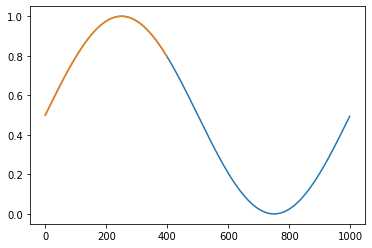

In [6]:
#Sine;input
offset = 400
imax = 735
nstep = 1000+offset #time step of simulation
dt = 0.005
omega = 2*3.1415926/(nstep-offset)/dt
SINE = np.zeros(nstep)
for i in range(nstep):
    SINE[i] = np.sin(omega*i*dt)     
SINE = (SINE + 1)/2
plt.plot(SINE[0:999])
plt.plot(SINE[1000:nstep])

In [7]:
filename = 'CKC STkernels-good parameters'

NGD_sigma_dict = dict()
NGD_sigma_dict['H'] = 1
NGD_sigma_dict['C'] = NGD_sigma_dict['H']*0.1 # RF size of cone cell
dx = NGD_sigma_dict['H']/40.

#dt=0.01  #large dt will cause  overflow
#nstep = int(1.6/dt)
NGD_sigma_dict['tau_y'] = 0.02
#Width setting
xlen = 50*NGD_sigma_dict['H'] #spatial extend of simulation
Dynamical_range = 6*NGD_sigma_dict['H']/dx #188-16 pixels
hw = 3*Dynamical_range*dx/22 #half bar width  #8 pixels
tempx = np.arange(0,xlen/dx+1)*dx

NGD_para_dict = {}
NGD_para_dict['alpha'] = 30. 
NGD_para_dict['beta'] = 1.2
NGD_para_dict['k'] = 20. #not important if there is no adaption
NGD_para_dict['phi'] = 1.
NGD_para_dict['g'] = 30. #but k*g are important


FBFF_sigma_dict = NGD_sigma_dict.copy()
FBFF_para_dict = NGD_para_dict.copy()
FBFF_para_dict['gramma'] = 100.
FBFF_para_dict['p'] = 100. # not important if there is no adaption
FBFF_para_dict['psy'] = 0.1

FBFF_sigma_dict['B'] = FBFF_sigma_dict['H']*0.5



# para_dict['g']*para_dict['k']*para_dict['phi']/para_dict['alpha']/para_dict['beta']

# TK

In [8]:
TDelta_input = np.zeros([int(2/dt), int(xlen/dx)+1])
TDelta_input[0,:] = 2
TDelta_output_w, zts, TDelta_output_y, _, _, _ = FB_FF_1l_1D(TDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
# Delta_output =Delta_output_w

Text(0.5, 1.0, 'temporal filter')

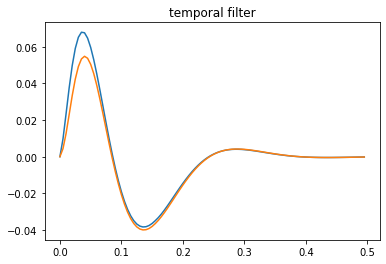

In [9]:
TKtaxis = np.arange(0,0.5,dt)
plt.plot(TKtaxis, TDelta_output_y[:len(TKtaxis),int(xlen/dx/2)])
tempTK = TDelta_output_w[:len(TKtaxis),int(xlen/dx/2)]
plt.plot(TKtaxis, tempTK)
plt.title('temporal filter')

In [10]:
delTK = TDelta_output_w[:len(TKtaxis),int(xlen/dx/2)]

# SK

In [11]:
SDelta_input = np.zeros([nstep, int(xlen/dx)+1])
SDelta_input[:, int(xlen/dx/2)] = 2
SDelta_output_w, zts, SDelta_output_y, _, _, _ = FB_FF_1l_1D(SDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

Text(0.5, 1.0, 'spatial filter')

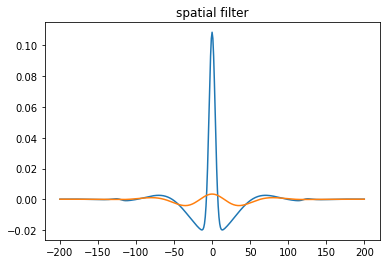

In [12]:
space_window = np.arange(-int(xlen/dx/10),int(xlen/dx/10)+1)
plt.plot(space_window, SDelta_output_y[-1,int(xlen/dx/2)+space_window])
plt.plot(space_window, SDelta_output_w[-1,int(xlen/dx/2)+space_window])
plt.title('spatial filter')

In [13]:
delSK = SDelta_output_w[-1,int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1]

# Spatio-Temporal Kernel

In [14]:
Delta_input = np.zeros([nstep, int(xlen/dx)+1])
Delta_input[0, int(xlen/dx/2)] = 2
Delta_output_w, zts, Delta_output_y, _, _, _ = FB_FF_1l_1D(Delta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

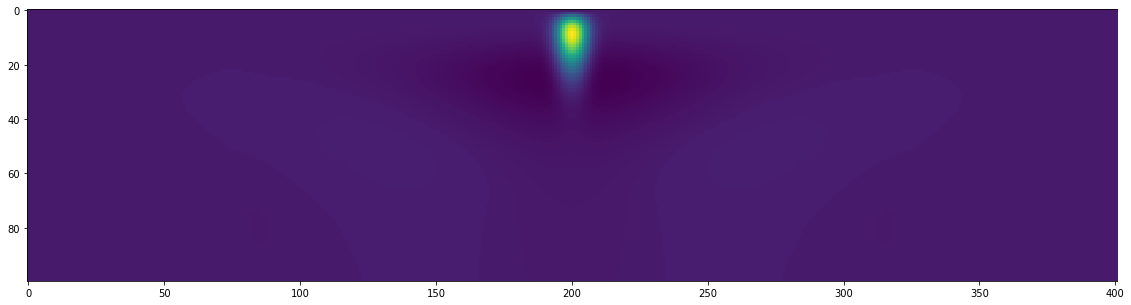

In [15]:
plt.imshow(Delta_output_y[:len(TKtaxis),int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1])
plt.gcf().set_size_inches(20, 5)

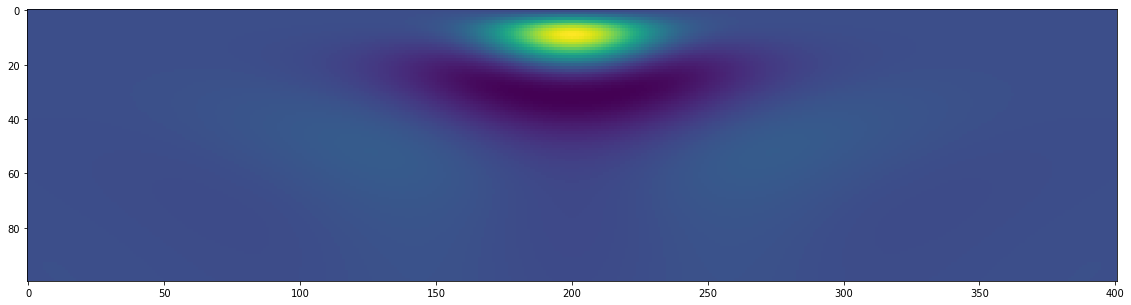

In [16]:
plt.imshow(Delta_output_w[:len(TKtaxis),int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1])
plt.gcf().set_size_inches(20, 5)

In [17]:
delSTK = Delta_output_w[:len(TKtaxis),int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1]

## find extreme

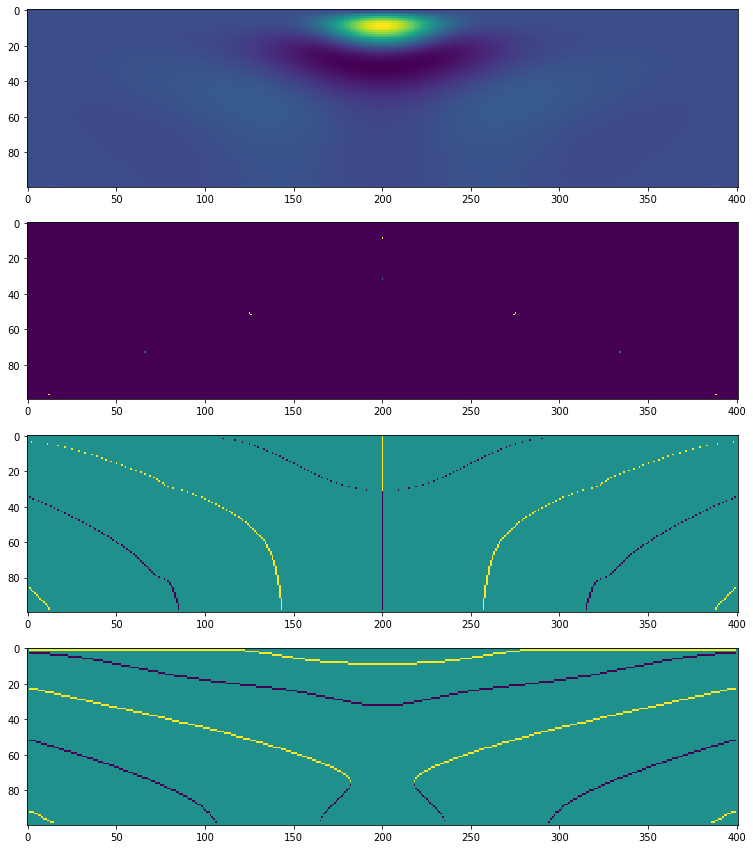

In [18]:
Peak = np.zeros_like(delSTK)
SPeak = np.zeros_like(delSTK)
TPeak = np.zeros_like(delSTK)
for i in np.arange(1,delSTK.shape[0]-1):
    for j in np.arange(1,delSTK.shape[1]-1):
        if delSTK[i,j]>delSTK[i+1,j] and delSTK[i,j]>delSTK[i-1,j]:
            TPeak[i, j] = 1
            if delSTK[i,j]>delSTK[i,j+1] and delSTK[i,j]>delSTK[i,j-1]:
                SPeak[i, j] = 1
                Peak[i, j] = 3
            elif delSTK[i,j]<delSTK[i,j+1] and delSTK[i,j]<delSTK[i,j-1]:
                SPeak[i, j] = -1
                Peak[i, j] = 2
        elif delSTK[i,j]<delSTK[i+1,j] and delSTK[i,j]<delSTK[i-1,j]:
            TPeak[i, j] = -1
            if delSTK[i,j]<delSTK[i,j+1] and delSTK[i,j]<delSTK[i,j-1]:
                SPeak[i, j] = -1
                Peak[i, j] = 1
            elif delSTK[i,j]>delSTK[i,j+1] and delSTK[i,j]>delSTK[i,j-1]:
                SPeak[i, j] = 1
                Peak[i, j] = 2
        else:
            if delSTK[i,j]<delSTK[i,j+1] and delSTK[i,j]<delSTK[i,j-1]:
                SPeak[i, j] = -1
            elif delSTK[i,j]>delSTK[i,j+1] and delSTK[i,j]>delSTK[i,j-1]:
                SPeak[i, j] = 1
fig, ax = plt.subplots(4,1)
ax[0].imshow(delSTK)
ax[1].imshow(Peak)
ax[2].imshow(SPeak)
ax[3].imshow(TPeak)
plt.gcf().set_size_inches(20, 15)

# Separate by Integration

In [19]:
iTk = np.sum(delSTK, axis = 1)*dx
iSk = np.sum(delSTK, axis = 0)*dt

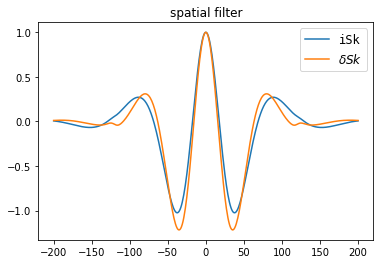

In [20]:
plt.plot(space_window, iSk/max(iSk))
plt.plot(space_window, delSK/max(delSK))
plt.title('spatial filter')

plt.legend( ('iSk', r'$\delta Sk$'), loc='best', prop={'size': 'large', 'family': 'monospace'})

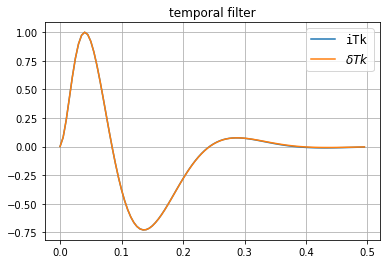

In [21]:
plt.plot(TKtaxis, iTk/max(iTk))
plt.plot(TKtaxis, delTK/max(delTK))
plt.grid()

plt.title('temporal filter')

plt.legend( ('iTk', r'$\delta Tk$'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [22]:
sSTk = iSk[np.newaxis,:]*iTk[:, np.newaxis]
# ssSTk = cut_Delta_output[np.newaxis,:]*np.flipud(n_TK[:len(iTk), np.newaxis])

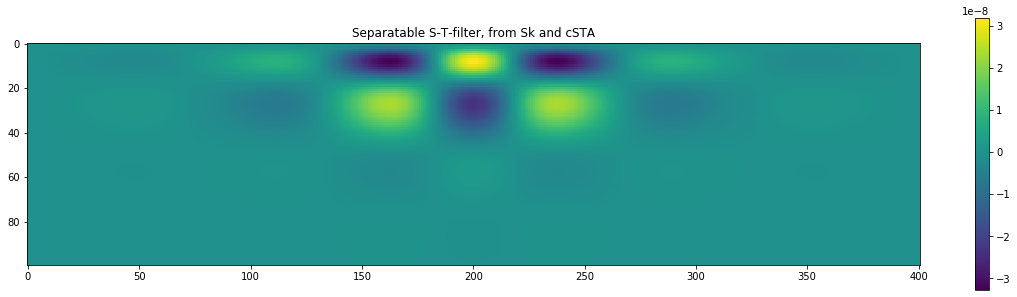

In [23]:
plt.imshow(sSTk)
plt.colorbar()
plt.title('Separatable S-T-filter, '+'from Sk and cSTA')
fig = plt.gcf()
fig.set_size_inches(20, 5)

# Apply SVD on Spatial-Temporal Kernel

In [24]:
from numpy import linalg as la
U,sigma,VT=la.svd(delSTK)

In [25]:
(sigma/sum(sigma))[:5]

array([0.63605268, 0.24901563, 0.08019158, 0.02821575, 0.00613582])

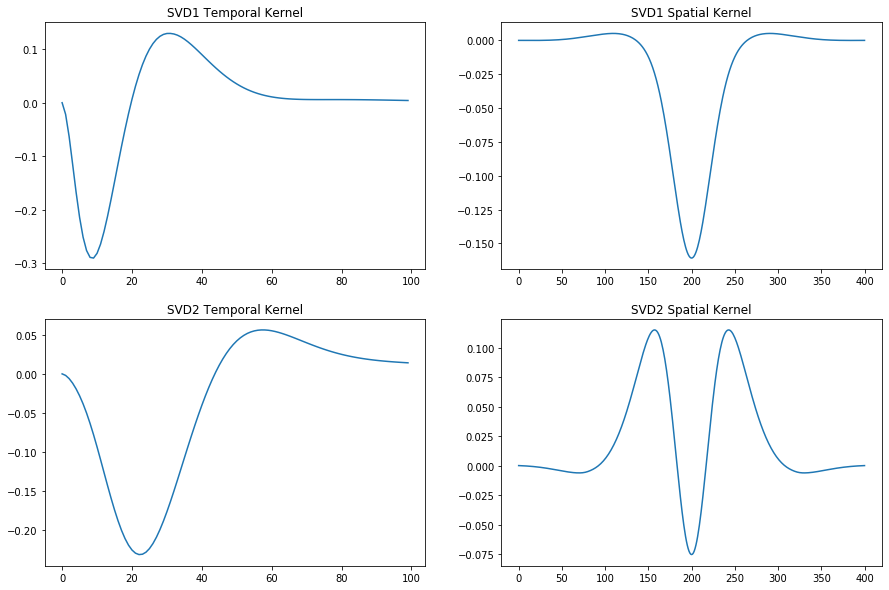

In [26]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

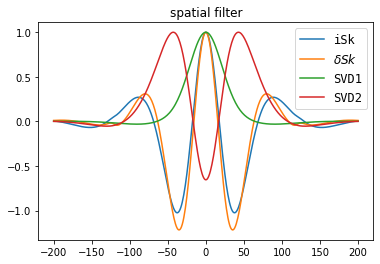

In [27]:
plt.plot(space_window, iSk/max(iSk), label = 'iSk')
plt.plot(space_window, delSK/max(delSK), label = r'$\delta Sk$')
plt.plot(space_window, -VT[0,:]/max(-VT[0,:]), label = 'SVD1')
plt.plot(space_window, VT[1,:]/max(VT[1,:]), label = 'SVD2')

plt.title('spatial filter')
plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

# plt.xlim([-30, 30])

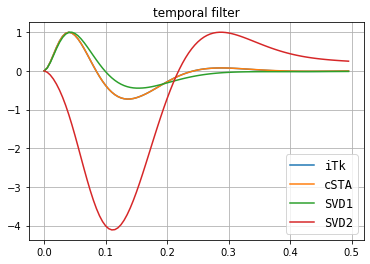

In [28]:
plt.plot(TKtaxis, iTk/max(iTk))
plt.plot(TKtaxis, delTK/max(delTK))
plt.plot(TKtaxis, -U[:,0]/max(-U[:,0]))
plt.plot(TKtaxis, U[:,1]/max(U[:,1]))
plt.grid()

plt.title('temporal filter')

plt.legend( ('iTk', 'cSTA', 'SVD1', 'SVD2'), loc='best', prop={'size': 'large', 'family': 'monospace'})

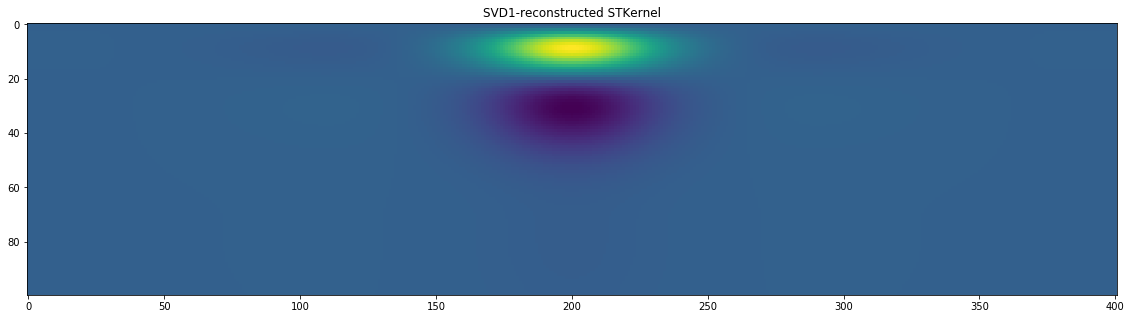

In [29]:
cSVD = 0
SVD_STkernel = np.matmul(U[:,cSVD][:, np.newaxis], VT[cSVD,:][np.newaxis, :])
plt.imshow(SVD_STkernel)
plt.title('SVD'+str(cSVD+1)+'-reconstructed STKernel')
fig = plt.gcf()
fig.set_size_inches(20, 5)

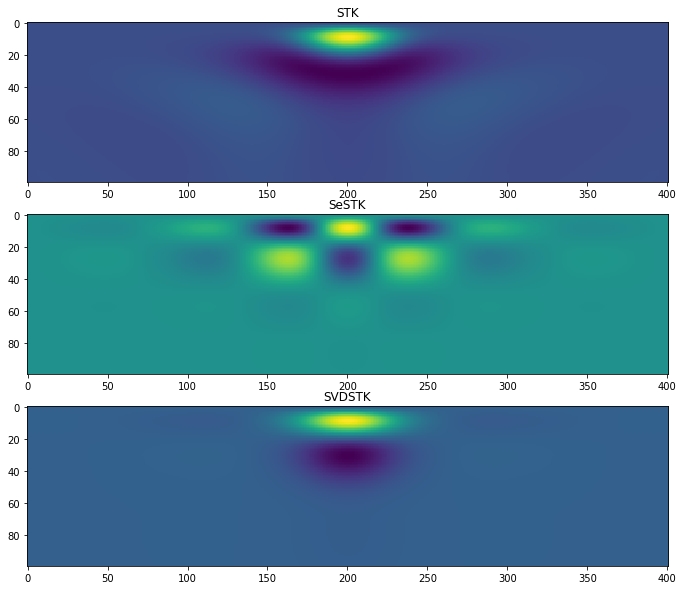

In [30]:
fig, ax = plt.subplots(3,1)
ax[0].imshow(delSTK)
ax[0].set_title('STK')
ax[1].imshow(sSTk)
ax[1].set_title('SeSTK')
ax[2].imshow(SVD_STkernel)
ax[2].set_title('SVDSTK')
plt.gcf().set_size_inches(20, 10)

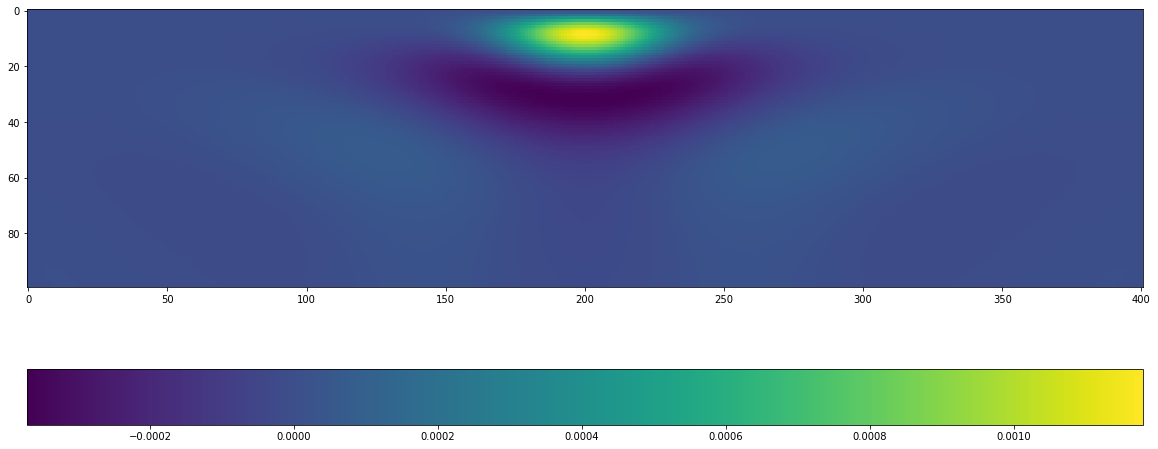

In [31]:
plt.imshow(delSTK)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(20, 10)

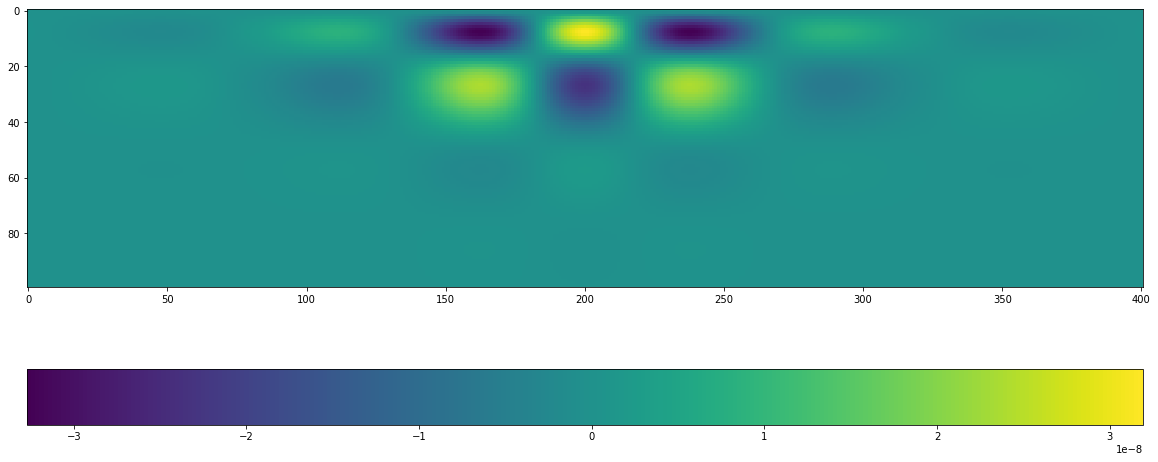

In [32]:
plt.imshow(sSTk)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(20, 10)

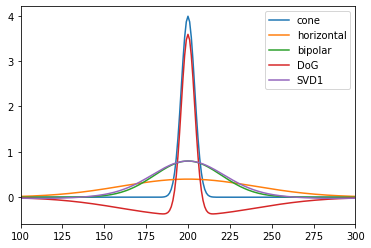

In [33]:
KC = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['C'])
KH = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['H'])
KB = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['B'])
plt.plot(KC, label = 'cone')
plt.plot(KH, label = 'horizontal')
plt.plot(KB, label = 'bipolar')
plt.plot(KC-KH, label = 'DoG')
plt.plot(-VT[0,:]/max(-VT[0,:])*max(KB), label = 'SVD1')

plt.xlim([200-100, 200+100])
plt.legend()

[ 9.4276025  22.82896487  1.25159602 87.7316686 ]


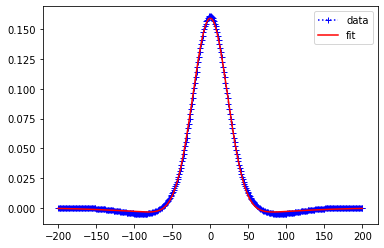

In [34]:
from scipy.optimize import curve_fit
SK = -VT[0,:]

def DoG(x, a1, sigma1, a2, sigma2):
    return a1*Gaussian_filter_1d(x,sigma1)-a2*Gaussian_filter_1d(x,sigma2)

popt,pcov = curve_fit(DoG, space_window, SK, p0=[max(SK), 23, 0.1*max(SK), 5*23], bounds = (0, np.inf))
# popt,pcov = curve_fit(DoG, space_window, SK, p0=[max(SK)/2, 23, -0.1*max(SK), 5*23])
print(popt)

plt.plot(space_window, SK, 'b+:', label='data')
plt.plot(space_window,  DoG(space_window, *popt), 'r-', label='fit')
plt.legend()

In [35]:
FBFF_sigma_dict

{'H': 1, 'C': 0.1, 'tau_y': 0.02, 'B': 0.5}

# Moving Bar

## delta

In [36]:
hbarwid = 100
ssigma = 70
moving_bar = np.zeros([nstep, int(xlen/dx)+1])
v = 1 #xstep/tstep
pos = 600
speak = np.zeros(nstep)
for i in range(nstep):
    #pos = pos+v
    pos = 400+SINE[i]*(int(xlen/dx)+1)*0.6
    ssigma = 100
    for ii in range(int(xlen/dx)+1):
        moving_bar[i, ii] = np.exp(-((ii-pos)/ssigma)**2)
pos

1356.1920216296726

In [37]:
wts, zts, yts, rpeak1 , rpeak2, rinvertpeak2  = FB_FF_1l_1D(moving_bar, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
SbS_output = wts

mb_y = STconvolve(moving_bar,delSTK,dx,dt)
SeSTK_y = STconvolve(moving_bar,sSTk,dx,dt)
SVDSTK_y = STconvolve(moving_bar,SVD_STkernel,dx,dt)

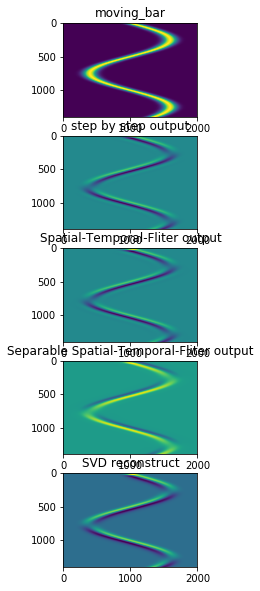

In [38]:
fig, ax = plt.subplots(5,1) 
ax[0].imshow(moving_bar)
ax[0].set_title('moving_bar')
ax[1].imshow(SbS_output)
ax[1].set_title('step by step output')
ax[2].imshow(mb_y)
ax[2].set_title('Spatial-Temporal-Fliter output')
ax[3].imshow(SeSTK_y)
ax[3].set_title('Separable Spatial-Temporal-Fliter output')
ax[4].imshow(SVDSTK_y)
ax[4].set_title('SVD reconstruct')
fig.set_size_inches(15, 10)

(-4, 1)

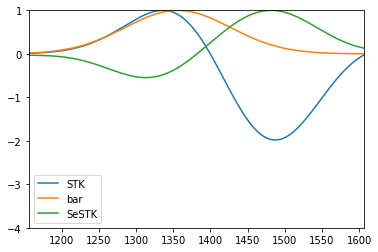

In [39]:
#plt.plot(SbS_output[-1,:]/max(SbS_output[-1,:]), label = 'Step by Step')
plt.plot(mb_y[-1,:]/max(mb_y[-1,:]), label = 'STK')
plt.plot(moving_bar[-1,:], label = 'bar')
plt.plot(SeSTK_y[-1,:]/max(SeSTK_y[-1,:]), label = 'SeSTK')
#plt.plot(SVDSTK_y[-1,:]/max(SVDSTK_y[-1,:]), label = 'SVDSTK')
plt.legend()
plt.xlim([pos-200,pos+250])
plt.ylim(-4,1)
#plt.xlim([pos-2*hbarwid,pos+2*hbarwid])

In [40]:
pos

1356.1920216296726

(0, 1)

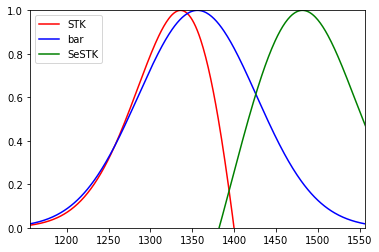

In [41]:
#plt.plot(SbS_output[-1,:]/max(SbS_output[-1,:]), label = 'Step by Step')
plt.plot(mb_y[-1,:]/max(mb_y[-1,:]), 'r',label = 'STK')
plt.plot(moving_bar[-1,:], 'b',label = 'bar')
plt.plot(SeSTK_y[-1,:]/max(SeSTK_y[-1,:]),'g', label = 'SeSTK')
#plt.plot(SVDSTK_y[-1,:]/max(SVDSTK_y[-1,:]), label = 'SVDSTK')
plt.legend()
#plt.xlim([pos-100,pos+50])
plt.xlim([pos-2*hbarwid,pos+2*hbarwid])
plt.ylim(0,1)

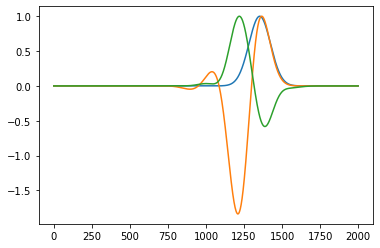

In [42]:
#preparation for movie
index = 100
s = np.transpose(moving_bar)# to get same topology as David
u1 = np.transpose(mb_y)
u2 = np.transpose(SeSTK_y)
plt.plot(s[:,index])
plt.plot(u1[:,index]/np.max(u1[:,index]))
plt.plot(u2[:,index]/np.max(u2[:,index]))

In [43]:
from matplotlib import animation, rc
from IPython.display import HTML

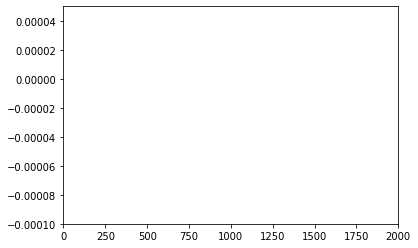

In [44]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2000))
ax.set_ylim((-0.0001, 0.00005))

line_r, = ax.plot([], [], 'r',lw=2)
line_b, = ax.plot([], [], 'b',lw=2)
line_g, = ax.plot([], [], 'g',lw=2)

In [45]:
# initialization function: plot the background of each frame
def init():
    line_r.set_data([], [])
    line_b.set_data([],[])
    line_g.set_data([],[])
    return (line_r,line_b,line_g,)

In [46]:
def animate(i):
    index = 3
    x = np.linspace(0, len(s[:,i+offset]),len(s[:,i+offset]))
    #y = -0.0001 +s[:,i]*0.00001
    y =   s[:,i+offset]*0.00002
    #z =  u1[:,i]/np.max(u1[:,i])
    #zz = u2[:,i]/np.max(u2[:,i])
    
    z =  u1[:,i+offset]
    zz = u2[:,i+offset]*20000
    
    line_r.set_data(x, z)
    line_b.set_data(x, y)
    line_g.set_data(x, zz)
    return (line_r,line_b,line_g,)

In [47]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nstep-offset, interval=40, blit=True)

In [48]:
HTML(anim.to_html5_video())

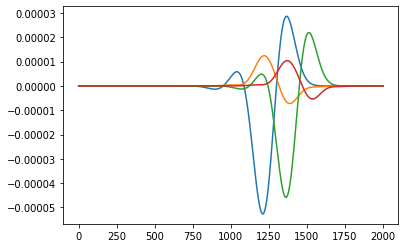

In [49]:
for i in range(100,200,50):
    plt.plot(u1[:,i])
    plt.plot(u2[:,i]*20000)

In [50]:
np.min(u1)

-5.9416925930081335e-05

In [51]:
np.max(u2)

7.43474268858423e-10